<a href="https://colab.research.google.com/github/lazysimon/NYCDSA_CapstoneProject/blob/master/als_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from urllib.request import urlopen

# utils import
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


%matplotlib inline

In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

spark-2.4.4-bin-hadoop2.7/
spark-2.4.4-bin-hadoop2.7/R/
spark-2.4.4-bin-hadoop2.7/R/lib/
spark-2.4.4-bin-hadoop2.7/R/lib/sparkr.zip
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/R.css
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/00Index.html
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/aliases.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/AnIndex
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdx
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdb
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/paths.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/te

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
movie_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/movies.dat'
rating_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/ratings.dat'

In [5]:
movieDF = pd.read_csv(movie_fname, sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
movieDF = movieDF.drop('Genres', 1)

ratingDF = pd.read_csv(rating_fname, sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
ratingDF = ratingDF.drop('Timestamp',1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [0]:
from pyspark import SparkContext
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
# mergeSQL = sqlCtx.createDataFrame(mergeDF)

In [13]:
ratingRDD = sqlCtx.createDataFrame(ratingDF)
ratingRDD = ratingRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")
def split_sets(ratings, proportions):
    split = ratings.randomSplit(proportions, seed=42)
    return {'training': split[0], 'validation': split[1], 'test': split[2]}
    
sets = split_sets(ratingRDD, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size = {}".format(sets['training'].count()))
print("Validation dataset size = {}".format(sets['validation'].count()))
print("Test dataset size = {}".format(sets['test'].count()))

Training dataset size = 506226
Validation dataset size = 148042
Test dataset size = 147023


In [0]:
def calc_se(rating, user_factor, item_factor):
    """Squared Error (SE) for a single rating and prediction"""
    prediction = user_factor.T.dot(item_factor)
    return (rating - prediction) ** 2

In [15]:
sets['training'].show(10)

+----+-------+------+
|user|   item|rating|
+----+-------+------+
|   1| 454876|    10|
|   1| 790724|     8|
|   1| 882977|     8|
|   1|1229238|     9|
|   1|1288558|     5|
|   1|1483013|     6|
|   1|1583421|     7|
|   1|1588173|     9|
|   1|2024432|     8|
|   1|2053463|     8|
+----+-------+------+
only showing top 10 rows



In [16]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(coldStartStrategy="drop")

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [6, 8]) \
    .addGrid(als.maxIter,[10, 12]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

%time model = tvs.fit(sets['training'])

CPU times: user 799 ms, sys: 142 ms, total: 941 ms
Wall time: 1min 47s


In [17]:
print("Best rank = {}".format(model.bestModel.rank))
print("Best maxIter = {}".format(model.bestModel._java_obj.parent().getMaxIter()))

Best rank = 6
Best maxIter = 12


In [21]:
print(movieDF.head(5))
print(ratingDF.head(5))
movieRDD = sqlCtx.createDataFrame(movieDF)
movieRDD = movieRDD.selectExpr("MovieId as item","Movie_title as title")
movieRDD.show()

   MovieId                                        Movie_Title
0        8      Edison Kinetoscopic Record of a Sneeze (1894)
1       10                La sortie des usines Lumière (1895)
2       12                      The Arrival of a Train (1896)
3       25  The Oxford and Cambridge University Boat Race ...
4       91                         Le manoir du diable (1896)
   UserId  MovieId  Rating
0       1   111161      10
1       1   117060       7
2       1   120755       6
3       1   317919       6
4       1   454876      10
+----+--------------------+
|item|               title|
+----+--------------------+
|   8|Edison Kinetoscop...|
|  10|La sortie des usi...|
|  12|The Arrival of a ...|
|  25|The Oxford and Ca...|
|  91|Le manoir du diab...|
| 131|Une nuit terrible...|
| 417|Le voyage dans la...|
| 439|The Great Train R...|
| 443|Hiawatha, the Mes...|
| 628|The Adventures of...|
| 833|The Country Docto...|
|1223| Frankenstein (1910)|
|1740|The Lonedale Oper...|
|2101|    Cleopatr

In [22]:
from pyspark.sql.functions import col
prediction = model.transform(sets['test'])
# movieRDD = movieRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")

prediction.alias('p').join(movieRDD.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

+-----+--------------------------------------+----------+------+
|user |title                                 |prediction|rating|
+-----+--------------------------------------+----------+------+
|21563|Only Angels Have Wings (1939)         |8.097015  |9     |
|41579|The Lost Weekend (1945)               |7.8466015 |9     |
|27802|The Lost Weekend (1945)               |7.432215  |8     |
|30478|The Lost Weekend (1945)               |8.68944   |9     |
|10478|The Lost Weekend (1945)               |8.8653965 |9     |
|41281|Lady and the Tramp (1955)             |5.703766  |7     |
|3833 |Lady and the Tramp (1955)             |8.06465   |9     |
|58043|Lady and the Tramp (1955)             |7.159296  |7     |
|40048|Lady and the Tramp (1955)             |7.388607  |9     |
|37987|Lady and the Tramp (1955)             |8.344354  |3     |
|17310|Lady and the Tramp (1955)             |7.3382983 |8     |
|36036|Lady and the Tramp (1955)             |7.168799  |8     |
|58054|The Blob (1958)   

(0, 10)

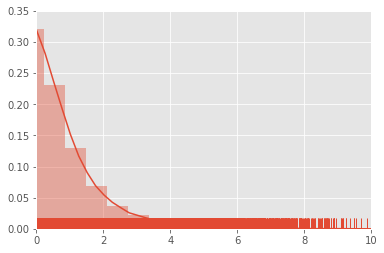

In [24]:
errors = prediction.withColumn('error', col('prediction')-col('rating')).select('error').collect()
ax = sns.distplot(errors, rug=True, hist=True)
ax.set_xlim(0, 10)

In [25]:
mse = evaluator.evaluate(prediction)
print("MSE = {}".format(mse))

MSE = 2.6891093381439415


In [26]:
# top 10 movies for all users
k = 10 
model.bestModel.recommendForAllUsers(k).show(10)

+----+--------------------+
|user|     recommendations|
+----+--------------------+
| 148|[[2812992, 13.083...|
| 471|[[6467380, 15.777...|
| 496|[[6467380, 17.672...|
| 833|[[6467380, 19.413...|
|1088|[[2812992, 16.107...|
|1342|[[6467380, 21.528...|
|1580|[[6467380, 13.527...|
|1591|[[902270, 14.6422...|
|1645|[[4772806, 19.378...|
|1829|[[6467380, 17.771...|
+----+--------------------+
only showing top 10 rows



In [53]:
user59169 = ratingRDD.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(user59169)) # 59168 users

New user id = 59169


In [29]:
from pyspark.sql.functions import lower

def find_movie_id(partial_title):
    movieRDD.where(lower(col('title')).like("%{}%".format(partial_title.lower())))\
    .show(truncate=False)
    
find_movie_id('avengers')

+-------+-------------------------------------+
|item   |title                                |
+-------+-------------------------------------+
|118661 |The Avengers (1998)                  |
|848228 |The Avengers (2012)                  |
|2395427|Avengers: Age of Ultron (2015)       |
|4154756|Avengers: Infinity War (2018)        |
|4154796|Avengers: Endgame (2019)             |
|4296026|Avengers Grimm (2015)                |
|5262972|Avengers: Age of Ultron Parody (2015)|
+-------+-------------------------------------+



In [45]:
find_movie_id('one day')

+-------+-------------------------+
|item   |title                    |
+-------+-------------------------+
|1563738|One Day (2011)           |
|1900946|One Day on Earth (2012)  |
|5598320|One Day I'll Leave (2015)|
|6168298|One Day (2016)           |
|6214734|One Day (2017)           |
+-------+-------------------------+



In [50]:
from pyspark.sql import Row
rating59169 = [
    (118661, 8), #Avengers
    (371746, 7), #Iron Man 2008
    (397535, 6), # Memoirs of a Geisha
    (94625, 9), # Akira
    (1563738,1) # One day 2011
    
]
user59169DF = spark.createDataFrame([Row(user=user59169, item=r[0], rating=r[1]) for r in rating59169])
user59169DF.show()

+-------+------+-----+
|   item|rating| user|
+-------+------+-----+
| 118661|     8|59169|
| 371746|     7|59169|
| 397535|     6|59169|
|  94625|     9|59169|
|1563738|     1|59169|
+-------+------+-----+



In [67]:
user59169DF = user59169DF.select('user','item','rating')
user59169DF.show()
type(user59169DF)

+-----+-------+------+
| user|   item|rating|
+-----+-------+------+
|59169| 118661|     8|
|59169| 371746|     7|
|59169| 397535|     6|
|59169|  94625|     9|
|59169|1563738|     1|
+-----+-------+------+



pyspark.sql.dataframe.DataFrame

In [64]:
ratingRDD2 = ratingRDD.union(user59169DF)
ratingRDD2.groupBy().max('user').first()['max(user)'] + 1
user59170 = ratingRDD2.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(user59170)) # 59168 users

New user id = 59170


In [65]:
best_rank = model.bestModel.rank
best_iterations = model.bestModel._java_obj.parent().getMaxIter()
%time new_model = ALS(rank=best_rank, maxIter=best_iterations, coldStartStrategy="drop").fit(ratingRDD2)

CPU times: user 58.9 ms, sys: 17.8 ms, total: 76.7 ms
Wall time: 12.4 s


In [80]:
unseen_movies = movieRDD.alias('m').join(user59169DF.alias('r'), col('m.item') == col('r.item'), how='left_anti').select('item')
unseen_movies.show(10)
print("Number of unseen movies = {}".format(unseen_movies.count()))

+-----+
| item|
+-----+
| 9968|
|31762|
|37098|
|37884|
|38108|
|38510|
|48280|
|49967|
|51418|
|54415|
+-----+
only showing top 10 rows

Number of unseen movies = 33995


In [81]:
from pyspark.sql.functions import lit

unseen_movies_user = unseen_movies.withColumn("user", lit(user59169))
unseen_movies_user.show()

+-----+-----+
| item| user|
+-----+-----+
| 9968|59169|
|31762|59169|
|37098|59169|
|37884|59169|
|38108|59169|
|38510|59169|
|48280|59169|
|49967|59169|
|51418|59169|
|54415|59169|
|61135|59169|
|61597|59169|
|64757|59169|
|64873|59169|
|65462|59169|
|65848|59169|
|66070|59169|
|66580|59169|
|67148|59169|
|69976|59169|
+-----+-----+
only showing top 20 rows



In [85]:
unseen_movies.show()

+-----+
| item|
+-----+
| 9968|
|31762|
|37098|
|37884|
|38108|
|38510|
|48280|
|49967|
|51418|
|54415|
|61135|
|61597|
|64757|
|64873|
|65462|
|65848|
|66070|
|66580|
|67148|
|69976|
+-----+
only showing top 20 rows



In [82]:
unseen_ratings = new_model.transform(unseen_movies_user)
unseen_ratings.show(10)

AnalysisException: ignored